# E12.프로젝트 : CIFAR-10 이미지 생성하기

* GAN을 학습하는 과정은 보기보다 까다롭습니다. 
  - 모델 구조, learning_rate, 파라미터 초기화, 생성자와 판별자의 경쟁 관계, 데이터의 특성 등 고려해야 할 것이 참 많습니다.

* 이번에는 앞에서 배운 FASHION-MNIST 데이터 생성용 DCGAN 모델구조를 이용해서 **CIFAR-10 데이터**를 생성하는 모델을 직접 만들어 봅시다.


* 모델 구현 및 학습의 전과정의 흐름은 거의 비슷하겠지만, 아래와 같이 몇 가지 달라지는 점이 있습니다.

  - 이미지 데이터의 shape가 (28, 28, 1)에서 `(32, 32, 3)으로 변경`됩니다. 생성자, 판별자 모델의 입출력 shape 및 모델 구조에 영향이 있습니다.
  - 이미지가 단색의 grayscale에서 `RGB 3채널의 컬러이미지로 변경`됩니다. 시각화 과정에서 고려할 점이 있습니다.
  - 입력데이터 전체 `차원이 3~4배 증가`하면서, 학습이 진행되는 양상이 다소 달라집니다.


* [참고](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/)

**루브릭**


|평가문항|	상세기준|
|:-------|:-------|
|1. GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다.|오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였다.|
|2. 생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다.|gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였다.|
|3. 추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였다.|제출 아이디어를 제출 프로젝트에 반영하고, 그 결과가 아이디어 적용 이전보다 향상되었음을 시각적으로 입증하였다.|

## STEP 0. 작업환경 구성하기

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

## STEP 1. 데이터셋 구성하기

`CIFAR-10` 데이터셋도 `tf.keras` 안에 있는 `datasets`에 포함되어 있어서, 아래와 같이 손쉽게 데이터셋을 구성할 수 있습니다.

* 학습에 사용할 train_x의 이미지를 `[-1, 1]`로 정규화합니다.
* 로드한 학습 데이터를 시각화를 통해 확인해 봅시다.
* `tf.data.Dataset` 모듈의 `fromtensorslices() 함수`를 사용하여 미니배치 데이터셋을 구성해 봅시다.

### Step 1-1. 데이터셋 가져오기

In [2]:
# cifar10 데이터셋 가져오기
cifar10 = tf.keras.datasets.cifar10

# 사진을 메모리에 올리기 
(train_x, _), (test_x, _) = cifar10.load_data()

print(f'train_x : {train_x.shape}')
print(f'test_x : {test_x.shape}')

train_x : (50000, 32, 32, 3)
test_x : (10000, 32, 32, 3)


* **`.load_data()` 함수**를 이용하여 cifar10 데이터 세트에 접근
  - **2개의 튜플을 반환**
    - 훈련 데이터 세트에 대한 입력과 출력 요소,  **(train_x, train_y)**
    - 테스트 데이터 세트에 대한 입력과 출력 요소,  **(test_x, test_y)**  
    
    
* 훈련용: 50k개 + 테스트용: 10k개의 32x32 픽셀 컬러 사진

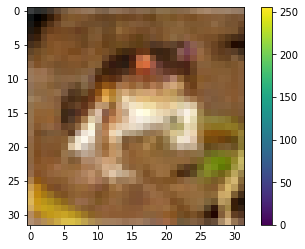

In [3]:
# 첫 번째 훈련 데이터 시각화
plt.imshow(train_x[0])
plt.colorbar()
plt.show()

### Step 1-2.  train_x의 이미지를 `[-1, 1]`로 정규화

In [4]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [5]:
# 이미지의 픽셀 값을 [0, 255] 에서 [-1, 1] 범위로 정규화
train_x = (train_x - 127.5) / 127.5

print("normalized max pixel:", train_x.max())
print("normalized min pixel:", train_x.min())

normalized max pixel: 1.0
normalized min pixel: -1.0


In [6]:
# 데이터셋의 shape
train_x.shape

(50000, 32, 32, 3)

* 생성자 모델은 **tanh 활성화 함수**를 사용하므로 **`[-1,1] 범위`** 의 픽셀 값으로 이미지를 생성

### Step 1-3. 학습 데이터 시각화

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


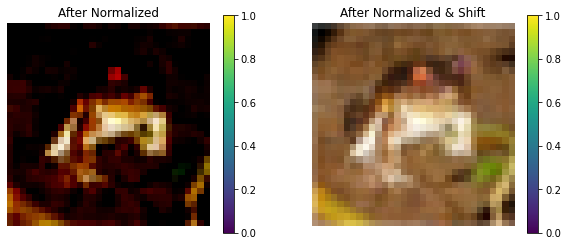

In [7]:
# 정규화된 첫 번째 훈련 데이터 확인
plt.figure(figsize=[10, 4])

plt.subplot(1, 2, 1)
plt.imshow(train_x[0])           # [-1, 1] 영역
plt.title('After Normalized')
plt.colorbar()
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow((train_x[0]+1.0)/2.0)     # 스케일 값 [0, 1]으로 조정
plt.title('After Normalized & Shift')
plt.colorbar()
plt.axis('off')

plt.show()

* **RGB 데이터**를 사용하여 imshow의 유효한 범위로 입력 데이터를 클리핑합니다 (실수의 경우 `[0..1]`, 정수의 경우 `[0..255]`).
* `[-1, 1]` 범위로 정규화된 RGB 이미지를 imshow() 함수로 표현하면 `[0, 1]` 범위 밖에 표현되지 않음
* 정규화를 `[0,1]` 범위로 다시 해야 하는 것인가?
  - No, 이미지를 보여줄 때에는 스케일 값을 RGB 범위에 맞게 조정하면 된다.

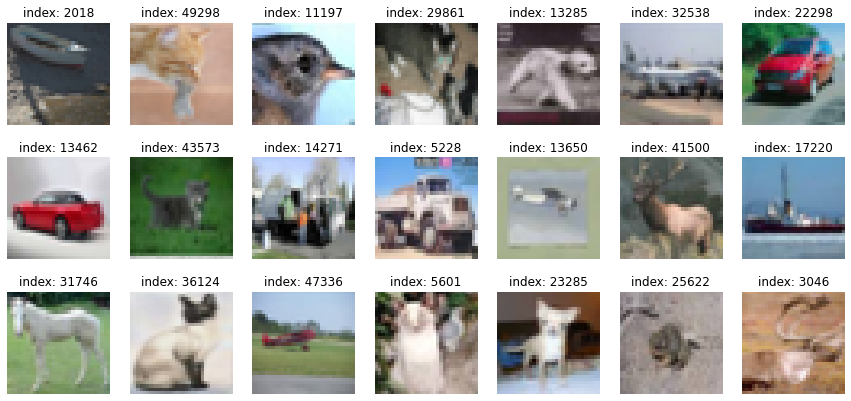

In [8]:
# 정규화된 이미지 21개를 3x7 의 배열로 띄워보기
plt.figure(figsize=(15, 7))

for i in range(21):
    plt.subplot(3, 7, i+1)
    random_index = np.random.randint(50000)       # 0~49999
    plt.imshow((train_x[random_index]+1.0)/2.0)  # cmap의 default: 'viridis'
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

### Step 1-4. 데이터셋 만들기

In [9]:
BUFFER_SIZE = 50000
BATCH_SIZE = 64

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset

<BatchDataset shapes: (None, 32, 32, 3), types: tf.float64>

* `tf.data.Dataset.from_tensor_slices()`
* 만약 모든 데이터가 메모리에 존재한다면, 이들로부터 Dataset을 만드는 가장 간단한 방법은 
  - `Dataset.from_tensor_slices()`를 사용하여 tf.Tensor로 변환하는 것입니다.
  
* `.shuffle(BUFFER_SIZE)` : 버퍼 크기를 사용하여 데이터를 섞는다.
* `.batch(BATCH_SIZE)` : 배치 크기만큼 데이터를 나눈다.

## STEP 2. 생성자 모델 구현하기

* (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.
* `noise = tf.random.normal([1, 100])`로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.
* 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다.


<img align='center' width='80%' height='80%' src='https://openai.com/content/images/2017/02/gen_models_diag_1.svg' />
<div style="text-align: center"> 참고 : https://openai.com/blog/generative-models/ </div>

### Step 2-1. (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수

In [10]:
# 생성자를 생성하는 함수
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(4*4*256, use_bias=False, input_shape=(100,)))  # (1, 100) noise vector
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))   # y = alpha*x   when x < 0

    # Second: Reshape layer
    model.add(layers.Reshape((4, 4, 256)))

    # Third: Conv2DTranspose layer  :  (4, 4, 256) → (8, 8, 128)
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fourth: Conv2DTranspose layer :  (8, 8, 128) → (16, 16, 64)
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fifth: Conv2DTranspose layer  : (16, 16, 64) → (32, 32, 3)
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))  

    return model

* **Padding**
  - Two types of padding options
    - **'valid'**: no padding (drop right-most columns & bottom-most rows)
    - **'same'**: padding size **`p = [(n(s-1)+(k-s))/2]`** when input_size = n, kernel size = k, strides= s
      - `p = (k-1)/2`   when `strides = 1`
  - Customized paddings can be given with ZeroPaddingnD layer (ZeroPadding1D, ZeroPadding2D, ZeroPadding3D)
  
* **`strides=(2, 2), padding='same'`**
  - `strides=(2, 2)`은 출력 크기를 입력 크기의 1/2로 줄인다.
  - `padding='same'`은 출력 크기를 입력 크기와 같게 한다.

* **입력** : 가우스 난수로 구성된 요소가 100 개인 벡터와 같은 공간의 점.
* **출력** : `[-1,1]`에 픽셀 값이있는 32 x 32 픽셀의 2 차원 정사각형 컬러 이미지 (3 채널).


* 생성자 모델을 개발하려면 
  - 100 차원의 공간에서 
  - 32 x 32 x 3 또는 3,072 값을 가진 2D 배열로 벡터를 변환


* (32, 32, 3) 이미지 크기가 생성되도록 레이어를 설정
  - `Dense(4*4*256)` 에서 시작
  - `strides=(2,2)` 조건으로 Conv2DTranspose() 3번 반복
  - 마지막 `Conv2DTranspose()` 레이어에서 3개 필터 사용

In [11]:
# 생성 모델을 generator라는 변수로 생성
generator = make_generator_model()

generator.summary()     # print(model.output_shape)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              409600    
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

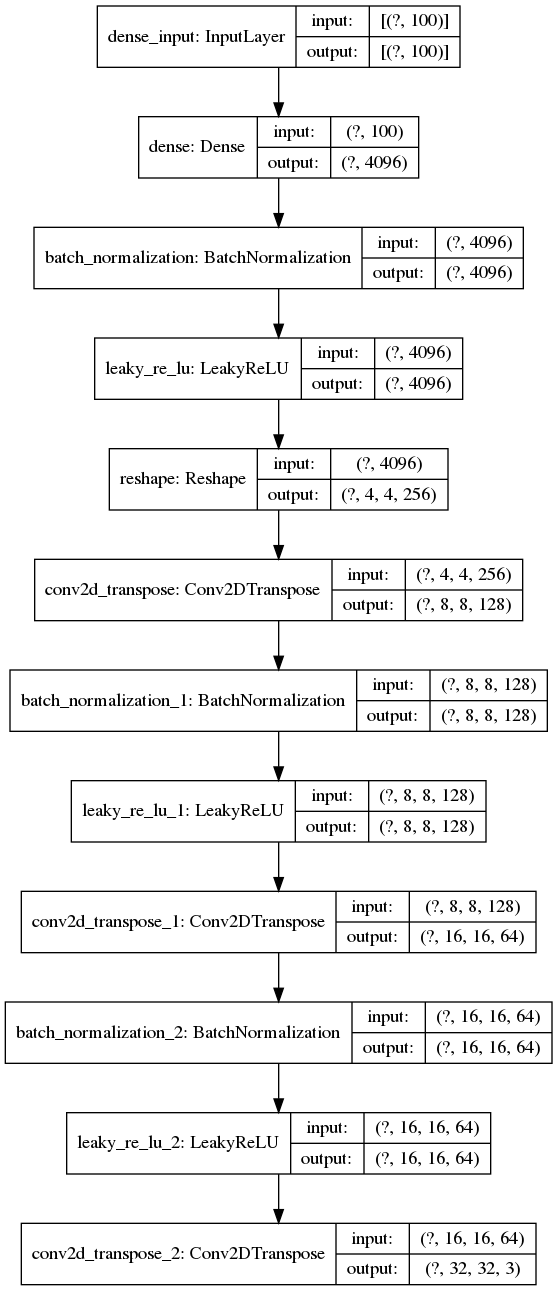

In [12]:
from tensorflow.keras.utils import plot_model

# plot the generator model
plot_model(generator, to_file='generator_plot.png', show_shapes=True, show_layer_names=True, rankdir='TB')

### Step 2-2.  랜덤 노이즈를 구현된 생성자로 랜덤 이미지 생성

In [13]:
#  랜덤 노이즈 벡터 생성
noise = tf.random.normal([1, 100])   # 평균 0, 분산 1
# noise = tf.random.uniform([1, 100], minval=-1., maxval=1., seed=2021)    # [-1, 1]

* `tf.random.normal(
    shape, mean=0.0, stddev=1.0, dtype=tf.dtypes.float32, seed=None, name=None)`
    - https://www.tensorflow.org/api_docs/python/tf/random/normal?hl=ko
    
    
* `tf.random.uniform(
    shape, minval=0, maxval=None, dtype=tf.dtypes.float32, seed=None, name=None)`
    - https://www.tensorflow.org/api_docs/python/tf/random/uniform?hl=ko

In [14]:
# 노이즈를 넣고 바로 모델을 호출하면 간단히 결과 이미지가 생성
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

### Step 2-3. 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인

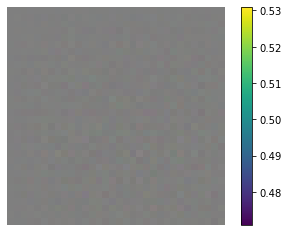

In [15]:
# 생성된 0번째 이미지 시각화
plt.imshow((generated_image[0]+1.0)/2.0)
plt.colorbar()
plt.axis('off')
plt.show()

## STEP 3. 판별자 모델 구현하기

* (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 봅시다.
* 위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 봅시다.

### Step 3-1.  1dim으로 판별결과를 출력하는 판별자 모델 구현 함수

In [16]:
# 판별자를 생성하는 함수
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer, DownSampling , (32, 32, 3) --> (16, 16, 64)
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(32, 32, 3)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer, DownSampling , (16, 16, 64) --> (8, 8, 128)
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Third: Conv2D Layer, DownSampling , (8, 8, 128) --> (4, 4, 256)
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Fourth: Flatten Layer
    model.add(layers.Flatten())

    # Fifth: Dense Layer, Classifying
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

* **판별자 모델**은 
  - 데이터 세트에서 샘플 이미지를 입력으로 가져옴 
  - 샘플이 실제인지 가짜인지에 대한 분류 예측을 출력
  - 이것은 **이진 분류 문제**


* **입력** : 
  - 3 색 채널과 
  - 32 × 32 픽셀 크기의 이미지.
* **출력** : 
  - 이진 분류, 
  - 샘플이 실제 (또는 가짜) 일 가능성.  


* 판별자 모델에는 입력 이미지를 **다운 샘플링하기 위해** 
  - **2x2 스트라이드**를 사용하는 3 개의 컨벌루션 레이어 추가  
  
  
* 판별자 모델에는 **입력 샘플이 실제인지 가짜인지를 예측하는** 
  - **시그모이드 활성화 함수**가 있는 출력 계층에 
  - 풀링 계층과 단일 노드가 없음   
  
  
* 판별자 모델은 **이진 분류에 적합한** 
  - **이진 교차 엔트로피 손실 함수**를 최소화하도록 훈련함

In [17]:
# 판별 모델을 discriminator라는 변수 이름으로 생성
discriminator = make_discriminator_model()

discriminator.summary()     # print(model.output_shape)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)        

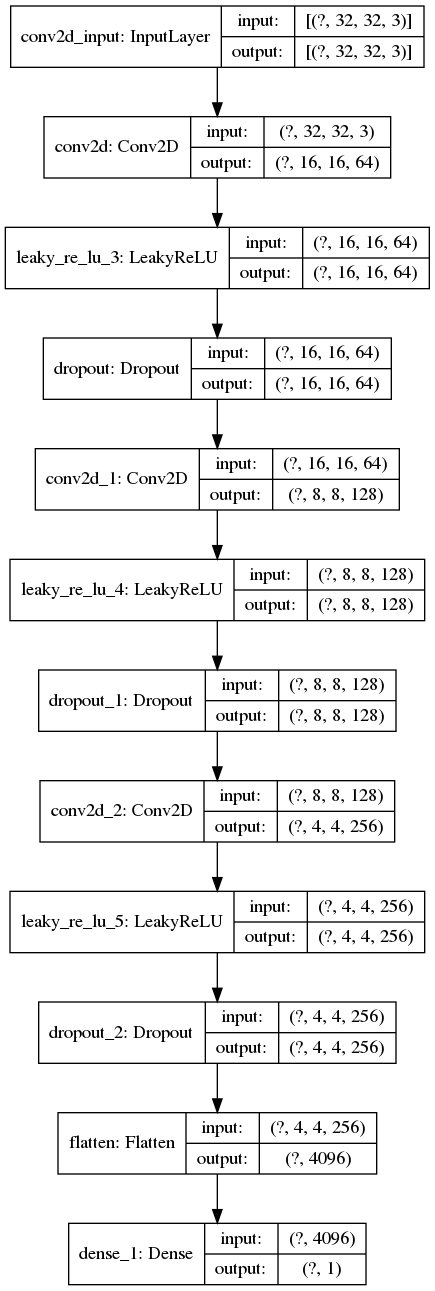

In [18]:
from tensorflow.keras.utils import plot_model

# plot the model
plot_model(discriminator, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

### Step 3-2. 랜덤 이미지를 판별자 모델이 판별한 결과값 확인

In [19]:
# 아까 생성했던 가짜 이미지를 판별자에 입력시키면 어떤 결과가 나올까
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.49943143]], dtype=float32)>

## STEP 4. 손실함수와 최적화 함수 구현하기

* 생성자와 판별자의 손실함수(loss)를 구현해 봅시다.
* 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅시다.
* 생성자와 판별자를 최적화하는 optimizer를 정의합니다.


### STEP 4-1. 생성자와 판별자의 손실함수(loss) 구현

In [20]:
# 손실함수를 cross_entropy라는 변수 이름으로 생성
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

* BinaryCrossentropy()

In [21]:
# 생성자 손실함수
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)    # 가짜 이미지를 진짜(1)처럼 생성

* `tf.ones_like(fake_output)`
  - fake_output 백터의 크기와 동일하며
  - 값은 1로 가득찬 백터를 만듦

In [22]:
# 판별자 손실함수
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)   # 진짜 이미지를 진짜(1)로 판별
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)  # 가짜 이미지를 가짜(0)로 판별
    total_loss = real_loss + fake_loss
    return total_loss

* `tf.zeros_like(fake_output)`
  - fake_output 백터의 크기와 동일하며
  - 값은 0로 가득찬 백터를 만듦

### Step 4-2. 이미지 판별 정확도(accuracy)를 계산하는 함수 구현

In [23]:
# 판별자 정확도
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

* `tf.constant(x)` : 상수 x 값을 생성
* `tf.math.greater_equal(y, x)` : y >= x 이면 True, 아니면 False 반환
* `tf.math.less(y, x)` : y < x 이면 True, 아니면 False 반환


* `tf.cast(x, dtype, name=None)` : 텐서를 새로운 형태로 캐스팅하는데 사용
  - 부동소수점형에서 정수형으로 바꾼 경우 소수점 버림
  - 조건식인 경우 조건이 True이면 1.0, False이면 0.0 반환 (`dtype=tf.float32`)
 
 
* `tf.reduce_mean()` : 배열 전체 평균
  - axis 파라미터로 계산할 축을 입력
    - `tf.reduce_mean(x, 0)`는 각 행들의 합으로, 즉, 열 단위로 평균
    - `tf.reduce_mean(x, 1)`는 각 열들의 합으로, 즉, 행 단위로 평균

### Step 4-3. 생성자와 판별자를 최적화하는 optimizer 정의

In [24]:
# 최적화 함수를 generator_optimizer 라는 변수 이름으로 생성 
generator_optimizer = tf.keras.optimizers.Adam(1e-4)

# 최적화 함수를 discriminator_optimizer 라는 변수 이름으로 생성 
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## STEP 5. 훈련과정 상세 기능 구현하기

* 1개 미니배치의 훈련 과정을 처리하는 `train_step() 함수`를 구현해 봅시다.
* 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 `generate_and_save_images() 함수`를 구현해 봅시다.
* 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 `draw_train_history() 함수`를 구현해 봅시다.
* training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 `checkpoint 모듈`을 설정해 봅시다.


### Step 5-1. 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수 구현

In [25]:
# 고정된 seed 노이즈를 만들기
noise_dim = 100                   # 100차원의 노이즈 생성
num_examples_to_generate = 16     # 한 번에 16장 가짜 이미지 생성

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [26]:
# 하나의 미니배치 당 진행할 train_step 함수

@tf.function
def train_step(images):  #(1) 실제 이미지 입력데이터
    # BATCH_SIZE=256, noise_dim=100
    noise = tf.random.normal([BATCH_SIZE, noise_dim])                    #(2) 가짜 이미지 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)               #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

* **train_step 함수**를 하나하나 뜯어보면

  - (1) 입력데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음
  - (2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함
  - (3) **`tf.GradientTape()`** 는 **가중치 갱신을 위한 Gradient를 자동 미분으로 계산**하기 위해 with 구문 열기
  - (4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성
  - (5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력
  - (6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산
  - (7) accuracy 계산 : fake_output, real_output으로 discriminator가
  - (8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산
  - (9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신
  - (10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴

* `tf.random.normal()`
* `tf.GradientTape()`
* `.gradient(y, x)` :  gradient 값을 통하여 W 값을 얻어내기 위한 그래프를 생성함
  - $\partial y/\partial x$ 계산
* `.apply_gradients()` : apply_gradients를 실행하여 W 값을 얻어옴
  - `tf.train.Optimizer.apply_gradients(grads_and_vars, global_step=None, name=None)`
* `.zip()` : 동일한 개수로 이루어진 자료형을 묶어 주는 역할

### Step 5-2. 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지 시각화

In [27]:
# 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)   # 16개 가짜 이미지 생성, model=generator

    fig = plt.figure(figsize=(4, 4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i]+1.0)/2.0)    
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

### Step 5-3. 훈련 epoch마다  loss와 accuracy를 시각화하는 함수


In [28]:
# 매 epoch마다 loss와 accuracy를 시각화하는 함수

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(2,1,1)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])
    
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(2,1,2)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

### Step 5-4.  정기적으로 모델 저장하기 위한 체크포인트 설정

In [29]:
# 정기적으로 모델 저장하기 위한 체크포인트 설정
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

* tf.train.Checkpoint()

## STEP 6. 학습 과정 진행하기

* 위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 봅시다.
* 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.
* 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출합니다.


(참고) 학습 과정 중 학습 epoch를 추가 진행해야 하거나, 학습한 모델을 활용하여 이미지를 생성할 필요가 생깁니다. 그럴 때마다 모델 학습을 처음부터 다시 진행한다면 시간 낭비가 될 것입니다.
우리는 위에서 checkpoint 모듈을 이용해 모델을 저장해 둔 바 있습니다. 이를 이용해 학습해 둔 모델을 로드하면 모델 재학습이 필요 없이 이런 작업을 진행할 수 있습니다.
아래는 checkpoint 모듈을 활용하여 모델을 로드하는 예시입니다.

* tf.train.latest_checkpoint()
* .restore()
* .numpy()
* 

In [30]:
# 모델 학습 시키는 함수
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):   # epochs=50 
        epoch_start = time.time()
        
        for it, image_batch in enumerate(dataset):    # 256개 실제 이미지
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)  # 이번 스텝에 계산된 loss와 accuracy를 리턴
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)   # seed=16개 가짜 이미지 생성
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)   # 16개 가짜 이미지 생성
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [31]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[]

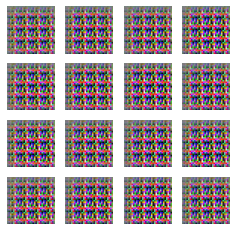

Epoch 30 | iter 151
Time for epoch 30 : 102 sec


KeyboardInterrupt: 

In [32]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/cifar10/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

In [33]:
# 학습 진행 과정을 확인
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 aiffel-d34j aiffel-d34j 1657732  3월  2 09:18 /home/aiffel-d34j/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


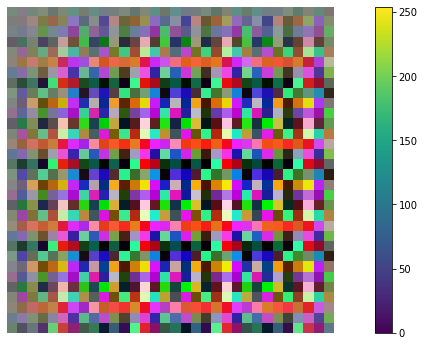

In [34]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.colorbar()
plt.axis('off')

plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

## STEP 7. (optional) GAN 훈련 과정 개선하기

* STEP 6을 진행하면서 생성된 샘플 이미지, 학습 과정 그래프 등을 통해 이전 훈련 과정의 문제점을 분석해 봅시다.
* 모델구조 또는 학습 과정을 개선한 내역과 그 결과(샘플 이미지, 학습 과정 그래프 포함)를 함께 제출합니다.


(참고) 아래 언급된 페이지들에서 개선을 위한 아이디어를 얻을 수 있을 것입니다.

* [How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks)
* [10 Lessons I Learned Training GANs for one Year](https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628)
* [Tips for Training Stable Generative Adversarial Networks](https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/)
* [Improved Techniques for Training GANs(paper)](https://papers.nips.cc/paper/2016/file/8a3363abe792db2d8761d6403605aeb7-Paper.pdf)

## 회고

* `[-1, 1]` 정규화 한 RGB 이미지를 `plt.imshow() 함수`로 보려고 하면 "`Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).`" 이와 같은 메시지를 출력하면서 이미지를 보여준다.
  - https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
    - (M, N, 3): an image with RGB values (0-1 float or 0-255 int).
    - 따라서 `[-1, 1]`로 정규화 하지 않고 `[0,1]`로 정규화 하였다.
   
   
* cmap (color map)의 값을 변경하여도 `plt.imshow() 함수`로 출력된 이미지의 색상에는 변화가 없었다.
  - https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
    - The Colormap instance or registered colormap name used to map scalar data to colors. 
    - This parameter is ignored for RGB(A) data.
    - 따라서 학습할 데이터는 RGB 칼라 이미지 이기 때문에 cmap의 값은 필요없어 삭제하였다.
    
    
* CNN(합성곱) 계층을 다룰 때 딥러닝에서 이미지를 다루려면 채널 수에 대한 차원이 필요하지만
  - train_x의 데이터 형태는 (32, 32, 3)으로 이미 채널의 수가 존재한다.
    - 따라서 reshape() 과정은 필요가 없기 때문에 생략하였다.


* BN (batch normalization) 을 이해하는데 오래 걸렸다.
  - covariate shift를 줄이는 방법
    - 평균 0, 분산 1로 정규화
    - $\gamma$(scale) 과 $\beta$(shift) 추가
  - non-linear 활성함수 앞쪽에 배치
  - back-propagation을 통해 학습이 가능
  - training 데이터 전체 또는 mini-batch 단위로 정규화
    - correlation이 적어 mini-batch가 전체 집합을 대표하도록 선정
  - 학습 시 : 각 mini-batch 마다 $\gamma$(scale) 과 $\beta$(shift)를 구하고 그 값을 저장
  - 테스트 시 : 학습 시 mini-batch 마다 구했던 $\gamma$(scale) 과 $\beta$(shift)의 평균을 사용
  
  
* Transpose Convolution 을 이해하는데 많은 시간이 소요되었다.
  - Convolution layer : input(i), kernel(k), padding(p), stride(s)
    - output feature map(o) : $$o = \frac{i+2p-k}{s} + 1$$
    
  - Transpose layer : 
    - $z = s-1, \;\;   p'=k-p-1, \;\;   s'=1$
    - Insert z number of zeros. 
      - Between each row and columns of the input
      - This increases the size of the input to $(2i-1)\times (2i-1)$
    - Pad the modified input image 
      - with p’ number of zeros
    - Carry out standard convolution on the image 
      - with a stride length of 1
    - output feature map(o) : $$o = (i-1)\times s+k-2p$$


# 끝